In [18]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import kerastuner as kt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import backend as K
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import RSquare

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Preprocessing

In [19]:
#  Import and read the charity_data.csv.
book_df = pd.read_csv("../../Resources/panda_df/books_cleaned_Trial2.csv")
book_df.head()

,isbn13,average_rating,book_id,format,num_pages,publication_year,ratings_count,text_reviews_count,author_average_rating
0,0000814474233,3.62,598454,Hardcover,220,2007,97,19,3.62
1,0008520919197,4.07,3623612,Paperback,288,2006,21,2,3.97
2,0008987086307,4.25,1776757,Paperback,250,2002,14,1,4.35
3,0031809055007,4.10,402191,Paperback,480,2000,402,26,4.13
4,0073999304862,3.68,1126975,Paperback,122,1999,22,2,3.82


In [20]:
# Determine the number of unique values in each column.
book_df.nunique()

isbn13                   83939
average_rating             309
book_id                  83939
format                       4
num_pages                 1130
publication_year            91
ratings_count             4612
text_reviews_count        1307
author_average_rating     1639
dtype: int64

In [21]:
# Drop the non-beneficial book_id and ISBN13 columns.
book_df = book_df.drop(["book_id", "isbn13"],axis=1)
book_df.head()

,average_rating,format,num_pages,publication_year,ratings_count,text_reviews_count,author_average_rating
0,3.62,Hardcover,220,2007,97,19,3.62
1,4.07,Paperback,288,2006,21,2,3.97
2,4.25,Paperback,250,2002,14,1,4.35
3,4.10,Paperback,480,2000,402,26,4.13
4,3.68,Paperback,122,1999,22,2,3.82


In [22]:
# Convert categorical data to numeric with `pd.get_dummies`
book_df = pd.get_dummies(book_df)

In [23]:
book_df.head()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,author_average_rating,format_Hardcover,format_Paperback,format_ebook,format_other
0,3.62,220,2007,97,19,3.62,1,0,0,0
1,4.07,288,2006,21,2,3.97,0,1,0,0
2,4.25,250,2002,14,1,4.35,0,1,0,0
3,4.10,480,2000,402,26,4.13,0,1,0,0
4,3.68,122,1999,22,2,3.82,0,1,0,0


In [24]:
# Split our preprocessed data into our features and target arrays
features = book_df.drop(columns=["average_rating"])
target = book_df["average_rating"]
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [25]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Identify the best hyperparameters using keras tuner

In [26]:
# Define keras tuner function
def build_model(hp):
    model = Sequential()

    #Allow Kerastuner to decide which activation function to use in the hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid', 'leaky_relu'])

    # Tune the number of units in the first Dense layer
    model.add(Dense(hp.Int('input_units', min_value=20, max_value=200, step=10), activation=activation, input_dim=9))

    # Tune the number of hidden layers and the number of units in each layer
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer for regression
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss='mean_squared_error',
                metrics=[RSquare(), 'mean_squared_error'])
    return model

tuner = kt.Hyperband(build_model,
                    objective=kt.Objective('r_square', direction="max"),
                    max_epochs=20,
                    factor=3,
                    project_name='keras_tuner_1.1')

tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 02m 24s]
r_square: 0.5684878826141357

Best r_square So Far: 0.5716946125030518
Total elapsed time: 00h 31m 30s


In [27]:
# View the best hyperparameters
best_hps.values

{'activation': 'tanh',
 'input_units': 40,
 'n_layers': 4,
 'dense_0_units': 192,
 'learning_rate': 0.0009444977587521196,
 'dense_1_units': 64,
 'dense_2_units': 96,
 'dense_3_units': 128,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

## Compile, Train and Evaluate the Model

In [28]:
# Define the model with the suggested hyperparameters
model = Sequential()

# Add the first Dense layer with the optimal number of units from the hyperparameter tuner
model.add(Dense(units=best_hps.get('input_units'), activation=best_hps.get('activation'), input_dim=9))

# Add the hidden layers, with the number of units being tuned
for i in range(best_hps.get('n_layers')):
    model.add(Dense(units=best_hps.get(f'dense_{i}_units'), activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
            loss='mean_squared_error',
            metrics=['mean_absolute_error', 'mean_squared_error', RSquare()])

In [29]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/50
1968/1968 [==============================] - 8s 3ms/step - loss: 0.1428 - mean_absolute_error: 0.2154 - mean_squared_error: 0.1428 - r_square: -0.1014 - val_loss: 0.0644 - val_mean_absolute_error: 0.1907 - val_mean_squared_error: 0.0644 - val_r_square: 0.5190
Epoch 2/50
1968/1968 [==============================] - 8s 4ms/step - loss: 0.0628 - mean_absolute_error: 0.1839 - mean_squared_error: 0.0628 - r_square: 0.5158 - val_loss: 0.0603 - val_mean_absolute_error: 0.1758 - val_mean_squared_error: 0.0603 - val_r_square: 0.5500
Epoch 3/50
1968/1968 [==============================] - 6s 3ms/step - loss: 0.0615 - mean_absolute_error: 0.1813 - mean_squared_error: 0.0615 - r_square: 0.5252 - val_loss: 0.0613 - val_mean_absolute_error: 0.1784 - val_mean_squared_error: 0.0613 - val_r_square: 0.5420
Epoch 4/50
1968/1968 [==============================] - 8s 4ms/step - loss: 0.0599 - mean_absolute_error: 0.1783 - mean_squared_error: 0.0599 - r_square: 0.5376 - val_loss: 0.0589 - val_mea

In [30]:
# Predicted values
predicted_ratings = model.predict(X_test_scaled)
actual_ratings = y_test

# Create a DataFrame with the actual and predicted values
ratings = pd.DataFrame({"Actual": actual_ratings, "Predicted": predicted_ratings.ravel()})
ratings.head(20)

656/656 [==============================] - 2s 2ms/step


,Actual,Predicted
53913,3.75,3.677593
25907,3.76,3.898363
43411,3.63,3.676602
1784,3.76,3.621957
13708,3.71,3.802972
25251,4.08,3.897569
62014,4.13,4.013819
81241,3.54,3.652469
48584,2.62,3.233858
9876,3.42,3.767962


In [31]:
ratings.describe()

,Actual,Predicted
count,20985.000000,20985.000000
mean,3.861825,3.848900
std,0.365927,0.276236
min,1.710000,2.436121
25%,3.650000,3.682241
50%,3.890000,3.853051
75%,4.110000,4.027440
max,5.000000,4.885967


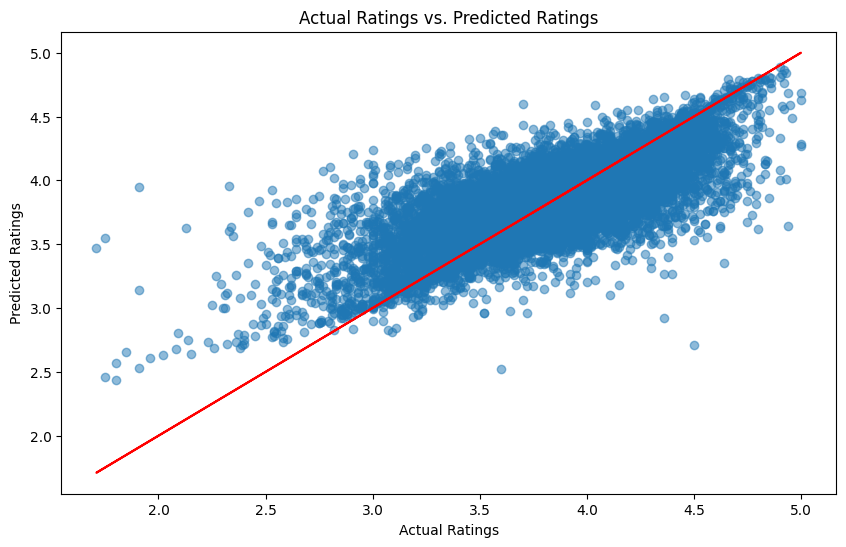

In [32]:
# Create a Scatter plot of actual versus predicted values
plt.figure(figsize=(10,6))
plt.scatter(ratings["Actual"], ratings["Predicted"], alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual Ratings vs. Predicted Ratings")

# Ideal line for perfect predictions
plt.plot(ratings["Actual"], ratings["Actual"], color='red')

plt.show()


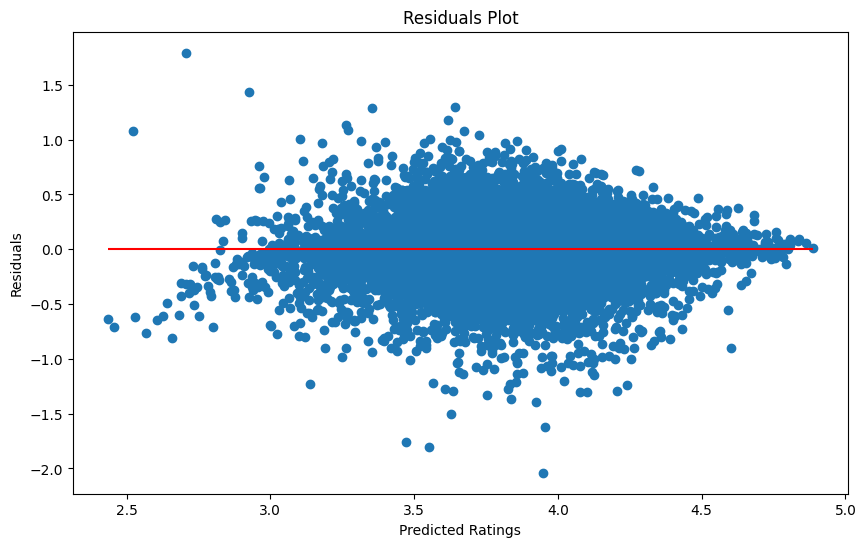

In [33]:
# Residual plot
residuals = ratings["Actual"] - ratings["Predicted"]
plt.figure(figsize=(10,6))
plt.scatter(ratings["Predicted"], residuals)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.hlines(y=0, xmin=ratings["Predicted"].min(), xmax=ratings["Predicted"].max(), linestyles='-', color='red')
plt.show()

In [34]:
loss, mae, mse, r2_score = model.evaluate(X_test_scaled,y_test )
print("Test RSquare: ", r2_score)

656/656 [==============================] - 2s 3ms/step - loss: 0.0559 - mean_absolute_error: 0.1688 - mean_squared_error: 0.0559 - r_square: 0.5824
Test RSquare:  0.582423210144043


In [35]:
# Calculate the mean absolute error (MAE) and mean squared error (MSE)
mae = mean_absolute_error(ratings["Actual"], ratings["Predicted"])
mse = mean_squared_error(ratings["Actual"], ratings["Predicted"])


print(f'MAE: {mae}')
print(f'MSE: {mse}')



MAE: 0.1688259572948704
MSE: 0.05591444731513663


<ipython-input-36-346244755587>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
<ipython-input-36-346244755587>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)


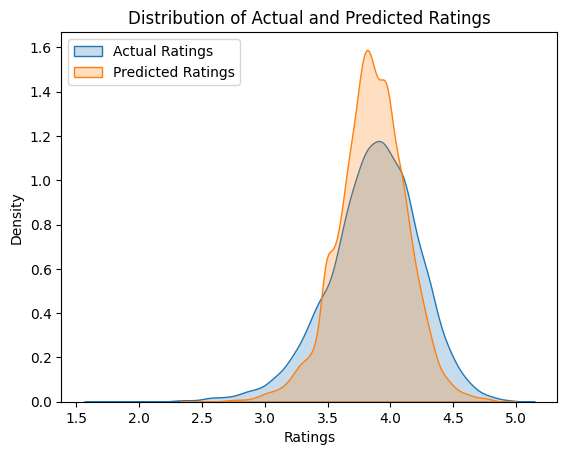

In [36]:
# Plot the distribution of actual and predicted ratings
sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)
plt.xlabel('Ratings')
plt.title('Distribution of Actual and Predicted Ratings')
plt.legend(loc='upper left')
plt.show()
